## **Predicting Housing prices using Advanced Regression Techniques**

In [1]:
import torch
from torch import nn
from torch import optim
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

## Setting up device agnostic code

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using: {device}\n")

Using: cpu



## Visualize the data



1.   Check for number of Null data in every column.
2.   Columns that have more than a 1000 Null data will be removed.

In [3]:
train_data = pd.read_csv("train.csv")
print(train_data.isnull().sum().to_string())
print(f"\nData shape: {train_data.shape}")

Id                  0
MSSubClass          0
MSZoning            0
LotFrontage       259
LotArea             0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          8
MasVnrArea          8
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           37
BsmtCond           37
BsmtExposure       38
BsmtFinType1       37
BsmtFinSF1          0
BsmtFinType2       38
BsmtFinSF2          0
BsmtUnfSF           0
TotalBsmtSF         0
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
1stFlrSF            0
2ndFlrSF            0
LowQualFin

3.   Check distribution of target values

<Axes: xlabel='SalePrice', ylabel='Count'>

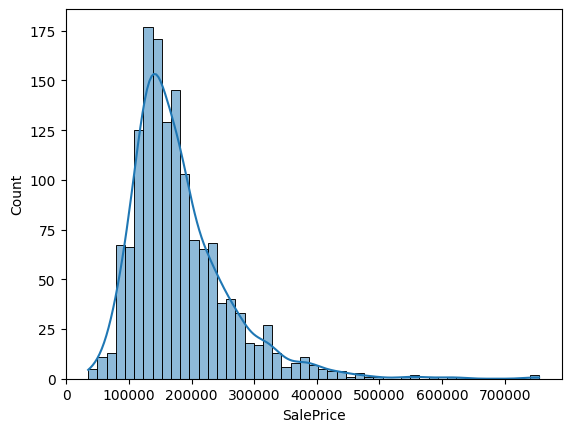

In [4]:
sb.histplot(train_data['SalePrice'], kde=True)



*   From the above graph we can infer that out target values are positively skewed, this may lead to misleading results.
*   We will apply log transformation on the data to transform into a normal distribution.



## Cleaning the data




*   The function cleanData prepares our data for processing.
*   It preforms the following actions on the data:
> 1.  Drops Columns that have more that a 1000 missing data along with the "Id", "SalesPrice" columns.

  > 2.  Applies Z-score normalization and replaces Null data with the mean for all columns with numeric data.







In [5]:
def cleanData(data = train_data):
    data = data.drop(columns=["Id","Alley", "PoolQC", "Fence", "MiscFeature", "SalePrice"], errors='ignore', axis=1)

    num_cols = data.select_dtypes(np.number).columns
    cat_cols = data.select_dtypes(include=['object']).columns

    data_cat = pd.get_dummies(data[cat_cols], dummy_na=True)
    data_num = data[num_cols].apply(lambda x: (x - x.mean()) / (x.std()))
    mean = data_num.mean(axis=0)
    data_num = data_num.fillna(mean)

    data = pd.concat([data_num, data_cat], axis=1)

    return data

<Axes: xlabel='SalePrice', ylabel='Count'>

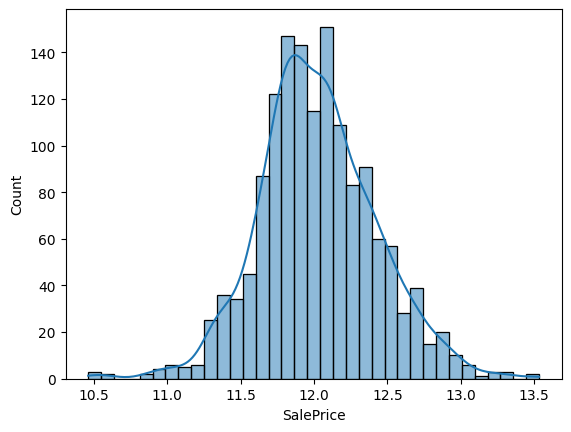

In [6]:
y_data = train_data["SalePrice"].copy()
X_data = cleanData()
y_data = np.log(y_data, where=y_data != 0)        # log transformation
sb.histplot(y_data, kde=True)

## Splitting Data and initializing dataloaders


*   80% of the data will be used for training wheras the remaining 20% will be used for validation



In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, train_size=0.8, random_state=42)

X_train = torch.tensor(X_train.values).float().to(device)
y_train = torch.tensor(y_train.values).float().unsqueeze(dim=1).to(device)
X_test = torch.tensor(X_test.values).float().to(device)
y_test = torch.tensor(y_test.values).float().unsqueeze(dim=1).to(device)

X_data_temp = X_data.copy()
X_data = torch.tensor(X_data.values).float().to(device)
y_data = torch.tensor(y_data.values).float().unsqueeze(dim=1).to(device)

BATCH_SIZE = 32
torch.manual_seed(42)
torch.cuda.manual_seed(42)

X_dataloader = TensorDataset(X_data,y_data)
X_dataloader = DataLoader(X_dataloader, batch_size=BATCH_SIZE, shuffle=False)

dataset_train = TensorDataset(X_train, y_train)
dataset_test = TensorDataset(X_test, y_test)

train_dataloader = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False)

## Defining the functions to train and evaluate the models

In [8]:
def train_step(model: nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device = device):

    train_loss = 0
    model.to(device)

    for batch, (X,y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(data_loader)

    return train_loss

In [9]:
def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              device: torch.device = device):

    test_loss = 0
    model.to(device)
    model.eval()

    with torch.inference_mode():
        for X ,y in data_loader:
            X, y = X.to(device), y.to(device)

            test_pred = model(X)
            test_loss += loss_fn(test_pred, y)

        test_loss /= len(data_loader)
        return test_loss

In [10]:
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.dataloader,
               loss_fn: torch.nn.Module,
               device: torch.device = device):
    loss = 0
    model.eval()

    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y)

        loss /= len(data_loader)
        loss = f"{loss:.3f}"

        y = torch.exp(y)
        y_pred = torch.exp(y_pred)

        errors = (y_pred - y).flatten().detach().cpu().numpy()
        mae = np.abs(errors).mean()
        rmse = np.sqrt(((errors)**2).mean())

    return {"model_name": model.__class__.__name__,
            "model_loss": loss,
            "MAE": mae,
            "RMSE": rmse}

In [11]:
def trainModel(model: torch.nn.Module,
               train_loader: torch.utils.data.dataloader,
               test_loader: torch.utils.data.dataloader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim,
               device: torch.device = device):
  training_loss = []
  testing_loss = []
  epoch_count = []

  for epoch in range(epochs):
      train_loss = train_step(data_loader=train_dataloader,
          model=model,
          loss_fn=loss_fn,
          optimizer=optimizer)
      test_loss = test_step(data_loader=test_dataloader,
          model=model,
          loss_fn=loss_fn)

      if epoch%50 == 0:
          print(f"Epoch: {epoch}\n---------")
          print(f"Train loss: {train_loss:.5f}")
          print(f"Test loss: {test_loss:.5f}\n")

## Building the models


In [12]:
loss_fn = nn.MSELoss()      #Mean Square Error Loss
epochs = 300

1. The first model incudes an input layer, one hidden layer,output layer and ReLu activation function in the end.

In [13]:
class LinearRegressionv0(nn.Module):
    def __init__(self, input_shape:int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(nn.Linear(in_features= input_shape,
                                                   out_features= hidden_units),
                                         nn.Linear(in_features= hidden_units,
                                                   out_features=hidden_units),
                                         nn.Linear(in_features=hidden_units,
                                                   out_features= output_shape),
                                         nn.ReLU())
    def forward(self, x):
        return self.layer_stack(x)


In [14]:
model_1 = LinearRegressionv0(input_shape=314, hidden_units=211, output_shape=1).to(device)
optimizer = optim.SGD(params=model_1.parameters(), lr=0.001)  #SGD optimizer

trainModel(model_1, train_dataloader, test_dataloader, loss_fn, optimizer)
model_results = eval_model(model=model_1,
                             data_loader=X_dataloader,
                             loss_fn=loss_fn)
model_results

Epoch: 0
---------
Train loss: 42.53319
Test loss: 0.62074

Epoch: 50
---------
Train loss: 0.05516
Test loss: 0.06245

Epoch: 100
---------
Train loss: 0.03221
Test loss: 0.03908

Epoch: 150
---------
Train loss: 0.02520
Test loss: 0.03180

Epoch: 200
---------
Train loss: 0.02163
Test loss: 0.02747

Epoch: 250
---------
Train loss: 0.01940
Test loss: 0.02523



{'model_name': 'LinearRegressionv0',
 'model_loss': '0.019',
 'MAE': 15312.375,
 'RMSE': 18761.062}

* Adding nesterov momentum to the optimizer with momentum = 0.5

In [15]:
model_2 = LinearRegressionv0(input_shape=314, hidden_units=211, output_shape=1).to(device)
optimizer = optim.SGD(params=model_2.parameters(), lr=0.001 , nesterov=True, dampening=0, momentum=0.5)   #SGD optimizer

trainModel(model_2, train_dataloader, test_dataloader, loss_fn, optimizer)
model_results = eval_model(model=model_2,
                             data_loader=X_dataloader,
                             loss_fn=loss_fn)
model_results

Epoch: 0
---------
Train loss: 25.74262
Test loss: 0.42637

Epoch: 50
---------
Train loss: 0.03379
Test loss: 0.04180

Epoch: 100
---------
Train loss: 0.02289
Test loss: 0.03143

Epoch: 150
---------
Train loss: 0.01905
Test loss: 0.02874

Epoch: 200
---------
Train loss: 0.01708
Test loss: 0.02235

Epoch: 250
---------
Train loss: 0.01528
Test loss: 0.02092



{'model_name': 'LinearRegressionv0',
 'model_loss': '0.015',
 'MAE': 15063.396,
 'RMSE': 19718.78}


*   Changing learning rate from 0.001 to 0.003 & increasing the number of hidden units from 211 to 471 to check for any significant difference.





In [16]:
model_3 = LinearRegressionv0(input_shape=314, hidden_units=471, output_shape=1).to(device)
optimizer = optim.SGD(params=model_3.parameters(), lr=0.003)  #SGD optimizer

trainModel(model_3, train_dataloader, test_dataloader, loss_fn, optimizer)
model_results = eval_model(model=model_3,
                             data_loader=X_dataloader,
                             loss_fn=loss_fn)
model_results

Epoch: 0
---------
Train loss: 17.57515
Test loss: 0.60101

Epoch: 50
---------
Train loss: 0.02753
Test loss: 0.03408

Epoch: 100
---------
Train loss: 0.02127
Test loss: 0.02593

Epoch: 150
---------
Train loss: 0.01755
Test loss: 0.02105

Epoch: 200
---------
Train loss: 0.01643
Test loss: 0.01913

Epoch: 250
---------
Train loss: 0.01426
Test loss: 0.01734



{'model_name': 'LinearRegressionv0',
 'model_loss': '0.013',
 'MAE': 14988.611,
 'RMSE': 18979.793}

* Adding 2 more hidden layers to check if we can reduce the loss any further

In [17]:
class LinearRegressionv1(nn.Module):
    def __init__(self, input_shape:int, hidden_units: int, output_shape: int):
      super().__init__()
      self.layer_stack = nn.Sequential(nn.Linear(in_features= input_shape,
                                                   out_features= hidden_units),
                                         nn.Linear(in_features= hidden_units,
                                                   out_features=hidden_units),
                                         nn.Linear(in_features= hidden_units,
                                                   out_features=hidden_units),
                                         nn.Linear(in_features= hidden_units,
                                                   out_features=hidden_units),
                                         nn.Linear(in_features=hidden_units,
                                                   out_features= output_shape),
                                         nn.ReLU())
    def forward(self, x):
      return self.layer_stack(x)

In [18]:
model_4 = LinearRegressionv1(input_shape=314, hidden_units=211, output_shape=1).to(device)
optimizer = optim.SGD(params=model_4.parameters(), lr=0.001)  #SGD optimizer

trainModel(model_4, train_dataloader, test_dataloader, loss_fn, optimizer)

model_results = eval_model(model=model_4,
                             data_loader=X_dataloader,
                             loss_fn=loss_fn)
model_results

Epoch: 0
---------
Train loss: 144.85522
Test loss: 144.09773

Epoch: 50
---------
Train loss: 0.04398
Test loss: 0.04764

Epoch: 100
---------
Train loss: 0.02668
Test loss: 0.03151

Epoch: 150
---------
Train loss: 0.02075
Test loss: 0.02508

Epoch: 200
---------
Train loss: 0.01817
Test loss: 0.02198

Epoch: 250
---------
Train loss: 0.01673
Test loss: 0.02036



{'model_name': 'LinearRegressionv1',
 'model_loss': '0.016',
 'MAE': 17068.135,
 'RMSE': 22485.846}

## Final Submission

* Choosing model3 as the final model we pass test.csv to get our predicted outputs.

* Here it seems that the data in test.csv has some missing columns.
We can fix this by adding a few rows and on each row we add the value that is missing on specific column

In [19]:
test_data = pd.read_csv("test.csv")

sub_id = test_data["Id"].copy()
X_sub = cleanData(test_data)
train_cols = X_data_temp.columns
sub_cols = X_sub.columns
diff = train_cols.difference(sub_cols)

added_rows = 0
idx = len(test_data)

test_data_temp = test_data.copy()
temp_row = test_data.iloc[0]

for string in diff:
    test_data_temp.append(temp_row)
    col, value = string.split('_')
    test_data_temp.loc[idx, col] = value
    idx += 1
    added_rows += 1

test_data_temp = cleanData(test_data_temp)
X_sub = test_data_temp.drop(test_data_temp.tail(added_rows).index)
X_sub = torch.tensor(X_sub.values).float().to(device)

y_sub = model_3(X_sub).squeeze()
y_sub = torch.exp(y_sub)
y_sub = y_sub.cpu().detach().numpy()
submission = pd.DataFrame({"Id":sub_id, "SalePrice":y_sub})
submission.to_csv('submission.csv', index=False)